Purpose of this notebook: 
* reads and summarizes the outputs from projections and smoothing
* creates LaTeX table for the paper 


In [753]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [657]:
%autoreload 2
%matplotlib inline 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rcParams['figure.figsize'] = (10, 8)
import pprint

In [216]:
from __future__ import print_function
from astropy.stats import biweight_location
import pandas as pd
import h5py
import sys
sys.path.append("../")
import extract_catalog as ec
import get_DM_centroids as getDM
# import seaborn as sns
import compute_distance as compDist
import plot_cred_int as plotCI
import plot_gal_prop as plotgal
import get_KDE

In [217]:
data_path = "../../data/test_results/"

# read in files 

In [218]:
clstNo = 43
date_stamp = '06_17_16'

DM_fhats = \
    h5py.File(data_path +
              "DM_fhat_clst{0}_{1}.h5".format(
            clstNo, date_stamp), 'r')
star_fhats = \
    h5py.File(data_path +
              "stars_fhat_clst{0}_{1}.h5".format(
            clstNo, date_stamp), 'r')
main_FOF_h5 = h5py.File(
        "../../data/" +
        "Illustris-1_fof_subhalo_myCompleteHaloCatalog_00135" +
        ".hdf5", "r")

In [219]:
star_no_dens_fhat = \
    h5py.File("../../data/test_results/" + 
              "stars_fhat_clst_no_density_43_06_25_16.h5")

## columns in my uber dataframe (projection independent part)
| ClstNo | $m_{200c}$ | richness | relaxedness0| relaxedness1 |  


## projection dependent part 
| ClstNo | kernel_width | $\Delta s_{BCG}$ | $\Delta s_{KDE}$ | $\zeta$ | $\Delta s_{SA}$ | $\Delta s_{C}$ |  projection | total_peaks_dens | 

ClstNo is retained to match and join the two sets of `df`

# gather the projection dependent part of the `uber_df`

In [557]:
stat_key_dict = {
    'BCG': r"$\Delta s_{\rm BCG}$", 
    'shrink_cent': r"$\Delta s_{\rm shrink}$'", 
    'KDE': r"$\Delta s_{\rm KDE}$'",
    'no_peak': r"$\Delta s_{\rm num KDE}$"
    }

The Uber DF contains offsets from between the galaxy KDE peak and the corresponding DM peaks

In [671]:
uber_df1 = pd.read_hdf("../../data/uber_df_06_17_16.h5", 'df')
uber_df2 = pd.read_hdf("../../data/uber_df_06_21_16.h5", 'df')
no_dens_df = pd.read_hdf('../../data/no_dens_dist_df.h5', 'df')
uber_df = pd.concat([uber_df1, uber_df2])

In [672]:
uber_df.keys()

Index([u'BCG', u'Delta_x_BCG', u'Delta_x_centroid', u'Delta_x_shrink_cent', u'Delta_y_BCG', u'Delta_y_centroid', u'Delta_y_shrink_cent', u'centroid', u'shrink_cent', u'peak_id', u'KDE', u'Delta_x_KDE', u'Delta_y_KDE', u'total_peaks_dens', u'bin_width'], dtype='object')

# make plots

In [684]:
dom_peak_gpby = uber_df.groupby(['peak_id', 'bin_width'])
dom_peak_df_25 = dom_peak_gpby.get_group((0, 25.0))
dom_peak_df_25.index = range(dom_peak_df_25.shape[0])
sum_stat_dom_peak_df = pd.concat([dom_peak_df_25, no_dens_df], 
                                 axis=1)
sum_stat_dom_peak_df.columns = \
    [u'BCG', u'Delta_x_BCG', u'Delta_x_centroid', 
     u'Delta_x_shrink_cent', u'Delta_y_BCG', 
     u'Delta_y_centroid', u'Delta_y_shrink_cent', 
     u'centroid', u'shrink_cent', u'peak_id', 
     u'KDE', u'Delta_x_KDE', u'Delta_y_KDE', 
     u'total_peaks_dens', 
     u'bin_width', 
     u'Delta_x_no_peak', 
     u'Delta_y_no_peak', 
     u'no_peak']

In [607]:
sum_stat_dom_peak_df.to_hdf('../../data/sum_stat_dom_peak_df.h5', 'df')

/Users/karenyng/Documents/illustris_analyses/code/IlEnv/lib/python2.7/site-packages/pandas/io/pytables.py:2558: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->axis0] [items->None]

  warnings.warn(ws, PerformanceWarning)
/Users/karenyng/Documents/illustris_analyses/code/IlEnv/lib/python2.7/site-packages/pandas/io/pytables.py:2558: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block0_items] [items->None]

  warnings.warn(ws, PerformanceWarning)


In [473]:
percentiles = {68L: int(.68 * sum_stat_dom_peak_df.shape[0]), 
               95L: int(.95 * sum_stat_dom_peak_df.shape[0]), 
               99L: int(.99 * sum_stat_dom_peak_df.shape[0])}

In [505]:
def compute_mag_p_value_intervals(df, stat_key, percentiles):
    sorted_stat = np.argsort(df[stat_key])
    return {k: df[stat_key][sorted_stat[v]]
               for k, v in percentiles.iteritems()}

In [559]:
p_value_intervals = {key: compute_p_value_intervals(
                          sum_stat_dom_peak_df, key, percentiles)
                     for key in stat_key_dict}

In [515]:
oneD_sum_stat_p_value_intervals = [
    pd.DataFrame(df, index=[key]) 
    for key, df in p_value_intervals.iteritems()]

In [516]:
pd.concat(oneD_sum_stat_p_value_intervals)

,68,95,99
KDE,40.225566,107.894565,152.025066
BCG,4.914816,311.877084,1661.338151
no_peak,125.451396,457.594718,904.985188
shrink_cent,119.151872,376.907396,864.545211


# make p-value level plots 

In [545]:
asym_sum_stat_df.transpose

,loc,low68,low95,up68,up95
BCG,2.830913,1.170400,0.278709,10.301319,1172.995385
shrink_cent,63.219417,13.256557,-6.674870,228.776754,555.060734
KDE,27.259697,10.796566,3.095278,64.124059,131.054541
no_peak,90.691058,42.212232,14.315034,183.553616,679.474348


# the 1D magnitude of the offsets by taking the  Euclidean distance (magnitude)

This gives a very asymmetrical distribution with discontinuity at $\Delta s = 0$. The density intervals in this plot is not right because we need the highest density interval. 

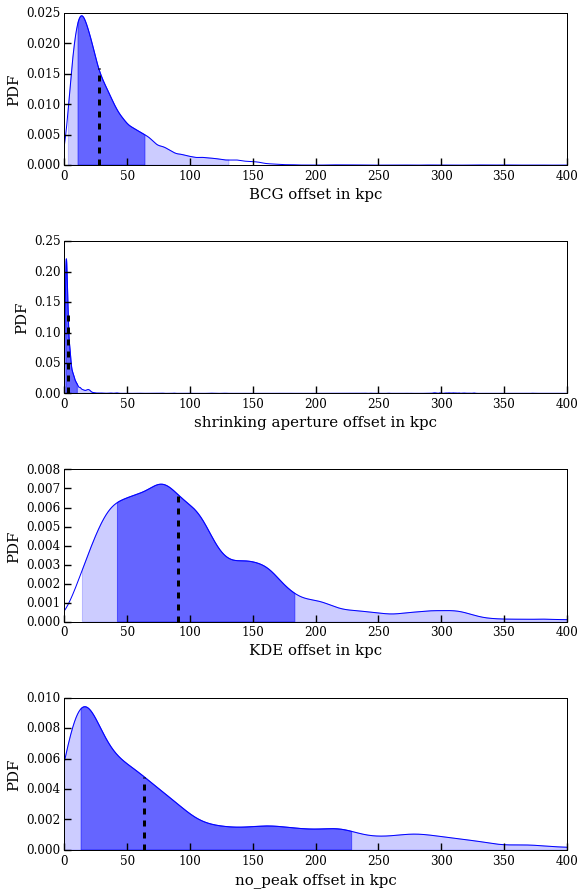

In [654]:
sum_stat_df_list = []
plt.figure(figsize=(18, 15))
gs = gridspec.GridSpec(4, 1)
gs.update(hspace=0.5, wspace=0.3)
gs.set_width_ratios([1., 1.])

ax_lists = [[plt.subplot(gs[row, col]) for col in range(1)]
            for row in range(4)] 

offset_labels = ['BCG', 'shrinking aperture', 'KDE', 'no_peak']
title_on = False
for i, stat in enumerate(stat_key_dict.keys()):
    ax1 = ax_lists[i][0]
    sum_stat1 = plotCI.CI_loc_plot(np.array(sum_stat_dom_peak_df[stat]), 
                                   ax=ax1)
    ax1.set_xlim(0, 400)
  
    ax1.set_ylabel('PDF')
    ax1.set_xlabel(offset_labels[i] + ' offset in kpc')
    ax1.tick_params(labeltop='off', labelright='off')
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if title_on:
        ax1.set_title(stat + 
                 " loc={0:.0f} $\pm$ {1:.0f}, {2:.0f}, {3:.0f}, {4:.0f}".format(
                 sum_stat1['loc'], sum_stat1['low68'], sum_stat1['up68'], 
                 sum_stat1['low95'], sum_stat1['up95'])
                )
    sum_stat_df_list.append(pd.DataFrame(sum_stat1, index=[stat]))
    ax.tick_params(labeltop='off', labelright='off')
    
    plt.savefig('../../paper/figures/finalized/Fig9_offset_distribution.png',
            bbox_inches='tight')
asym_sum_stat_df = pd.concat(sum_stat_df_list)

for final results there will be several tables:
* 

# plot the final distribution in a symmetrical way

In [578]:
sym_sum_stat_df.keys()

Index([u'Delta_x_BCG', u'Delta_x_KDE', u'Delta_x_no_peak', u'Delta_x_shrink_cent'], dtype='object')

In [705]:
one_direction_stat_dict = {
    "Delta_y_BCG": r"$\Delta y_{\rm BCG}$",
    "Delta_y_shrink_cent": r"$\Delta y_{\rm shrink}'$",
    "Delta_y_KDE": r"$\Delta y_{\rm KDE}'$",
    "Delta_y_no_peak": r"$\Delta y_{\rm num. dens}$",
}

In [814]:
def plot_offset_along_1_dimension(
        df, stat_key_dict, save=False, lvls=[68., 95., 99.],
        savefile=None):
    key_length = len(stat_key_dict)
    sum_stat_df_dict = {}
    fig = plt.figure(figsize=(18, 3 * key_length))
    gs = gridspec.GridSpec(key_length, 1)
    gs.update(hspace=0.3)
    gs.set_width_ratios([1., 1.])
    
    
    ax_lists = [[fig.add_subplot(gs[row, col]) for col in range(1)]
            for row in range(key_length)] 
    
    for i, stat in enumerate(stat_key_dict):
        ax = ax_lists[i][0]
        sum_stat_df_dict[stat] = \
            plotCI.CI_loc_plot(
                np.array(df[stat]), ax=ax, lvls=lvls)
        ax.set_xlim(-400, 400)
        ax.set_xlabel(stat_key_dict[stat] + ' (kpc)')
        ax.set_ylabel('PDF')
        ax.tick_params(labeltop='off', labelright='off')
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    
    if save and savefile is not None:
        fig.savefig(savefile, bbox_inches='tight')
    elif save and savefile is None:
        raise ValueError("`savefile` cannot be None.")
        
    return sum_stat_df_dict

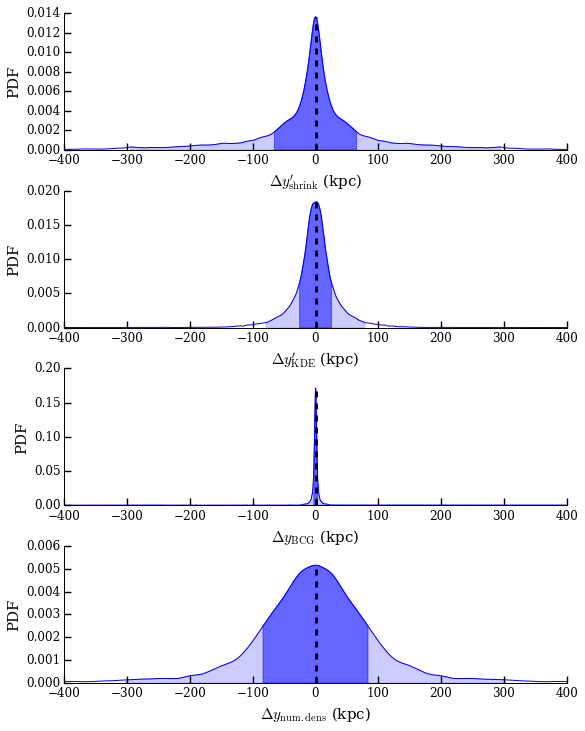

In [824]:
sym_sum_stat_df_dict = plot_offset_along_1_dimension(
        sum_stat_dom_peak_df, one_direction_stat_dict, 
        save=True, 
        savefile='../../paper/figures/finalized/fig5_symmetrical_1D_pdf.png'
)

# massage results and save to LaTeX

In [613]:
sym_sum_stat_df = pd.DataFrame(sym_sum_stat_df_dict)

In [614]:
dom_peak_df_25.index = no_dens_df.index

In [627]:
sym_sum_stat_df.columns = \
   [one_direction_stat_dict[k] for k in sym_sum_stat_df.keys()]

In [633]:
sym_sum_stat_df.index = [
    u'location', 
    u'lower 68\%', 
    u'lower 95\%', 
    u'lower 99\%', 
    u'upper 68\%', 
    u'upper 95\%', 
    u'upper 99\%']

\begin{tabular}{lrrrrrrr}
\toprule
{} &  location &  lower 68\% &  lower 95\% &  lower 99\% &  upper 68\% &  upper 95\% &  upper 99\% \\
\midrule
$\Delta y_{\rm BCG}$       &         0 &          -3 &         -22 &        -496 &           3 &         456 &        1449 \\
$\Delta y_{\rm KDE}'$      &         0 &         -25 &         -79 &        -127 &          25 &          79 &         126 \\
$\Delta y_{\rm num. dens}$ &        -0 &         -84 &        -303 &        -693 &          84 &         302 &         691 \\
$\Delta y_{\rm shrink}'$   &        -0 &         -65 &        -295 &        -652 &          65 &         295 &         655 \\
\bottomrule
\end{tabular}


# write out results in df to latex table

In [576]:
from collections import OrderedDict
key_mapping = OrderedDict([
 (u'BCG', r"$|\Delta s_{\rm BCG}|$"), 
 (u'Delta_x_BCG', r"$\Delta x_{\rm BCG}$"),
 (u'Delta_y_BCG', r"$\Delta y_{\rm BCG}$"), 
 (u'centroid', r"$|\Delta s_{\rm centroid}'|$"), 
 (u'Delta_x_centroid', r"$\Delta x_{\rm centroid}'$"), 
 (u'Delta_y_centroid', r"$\Delta y_{\rm centroid}'$"), 
 (u'shrink_cent', r"$|\Delta s_{\rm shrink}'|$"),
 (u'Delta_x_shrink_cent', r"$\Delta x_{\rm shrink}'$"), 
 (u'Delta_y_shrink_cent', r"$\Delta y_{\rm shrink}'$"),
 (u'KDE', r"$|\Delta s_{\rm KDE}'|$"), 
 (u'Delta_x_KDE', r"$\Delta x_{\rm KDE}'$"), 
 (u'Delta_y_KDE', r"$\Delta y_{\rm KDE}'$"), 
 (u'no_dens_dist', r"$\Delta s_{\rm num. KDE}$"),
 (u'Delta_no_peak_x', r"$\Delta x_{\rm num. KDE}$"), 
 (u'Delta_no_peak_y', r"$\Delta y_{\rm num. KDE}$")
]
)

In [569]:
sum_stat_all_peak_df = all_peak_df[key_mapping.keys()].describe()

In [570]:
sum_stat_all_peak_df.columns = key_mapping.values()

In [573]:
sum_stat_all_peak_df = sum_stat_all_peak_df.transpose()[
    [u'mean', u'std', u'min', u'25%', u'50%', u'75%', u'max']]

In [574]:
def str_formatter(float_str):
    return '{0:.0f}'.format(float_str)

In [575]:
with open("../../paper/full_sum_stat_table.tex", "w") as f:
    f.write(sum_stat_all_peak_df.to_latex(
            escape=False, float_format=str_formatter))

In [345]:
!cat ../../paper/full_sum_stat_table.tex

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &  mean &  std &   min &  25% &  50% &  75% &  max \\
\midrule
$\Delta s_{\rm BCG}$       &  33024 &    69 &  294 &     0 &    2 &    3 &    7 & 2335 \\
$\Delta x_{\rm BCG}$       &  33024 &   -14 &  226 & -2331 &   -2 &   -0 &    1 & 2327 \\
$\Delta y_{\rm BCG}$       &  33024 &    23 &  197 & -1980 &   -2 &    0 &    2 & 2332 \\
$\Delta s_{\rm centroid}$' &  33024 &   261 &  209 &     2 &  114 &  202 &  317 & 1103 \\
$\Delta x_{\rm centroid}$' &  33024 &   -42 &  224 & -1022 & -164 &  -37 &   66 & 1101 \\
$\Delta y_{\rm centroid}$' &  33024 &     0 &  244 & -1102 & -111 &   -0 &  111 & 1100 \\
$\Delta s_{\rm shrink}$'   &  33024 &   118 &  156 &     0 &   21 &   60 &  165 & 1454 \\
$\Delta x_{\rm shrink}$'   &  33024 &    -7 &  131 & -1089 &  -39 &   -3 &   23 &  969 \\
$\Delta y_{\rm shrink}$'   &  33024 &     0 &  145 & -1091 &  -32 &    0 &   32 & 1109 \\

$\Delta x_{\rm KDE}$'      &  33024 &    -2 &   35 &  -330 &  -17 &   -2 &   1

# gather the projection independent part of our uber dataframe

In [644]:
uber_prop_df = compDist.construct_uber_result_df(
    star_fhats, DM_fhats, main_FOF_h5
)

# check if things look consistent with 2D vis

In [763]:
def plot_2D_offsets(df, stat_key):
    for i, key in enumerate(stat_key) :
        plt.axes().set_aspect('equal')
    
        plt.plot(
            np.array(df['Delta_x_' + key]), 
            np.array(df['Delta_y_' + key]),
            'b.', alpha=0.05
            )
        biweight_loc = (
            biweight_location(df['Delta_x_' + key]), 
            biweight_location(df['Delta_y_' + key]))
    
        # The red cross is the biweight location along each dimension
        plt.plot(biweight_loc[0], biweight_loc[1],
             'rx', mew=2.)
        plt.tick_params(labeltop='off', labelright='off')
        plt.axes().yaxis.set_ticks_position('left')
        plt.axes().xaxis.set_ticks_position('bottom')
        plt.xlim(-300, 300)
        plt.ylim(-300, 300)
        plt.title(key + ', biweight_loc = {0:.2f}, {1:.2f}'.format(
            *biweight_loc))
    
        plt.show()
        plt.clf()

In [783]:
stat_key['centroid'] = "$\Delta s_{\rm centroid}'$"

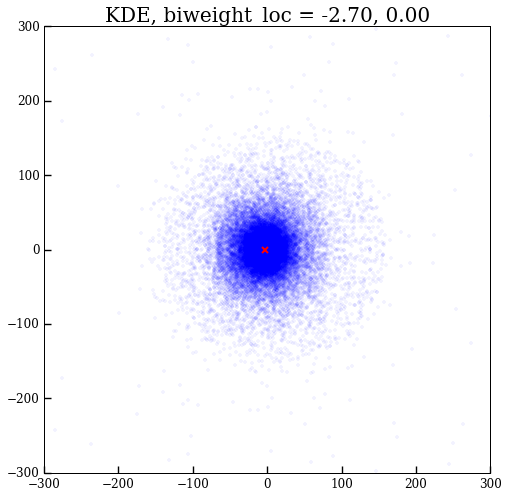

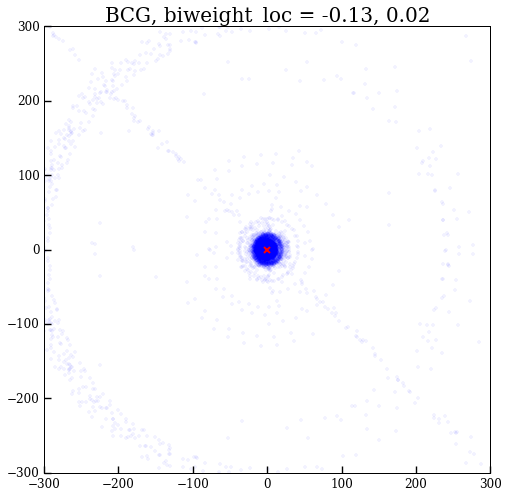

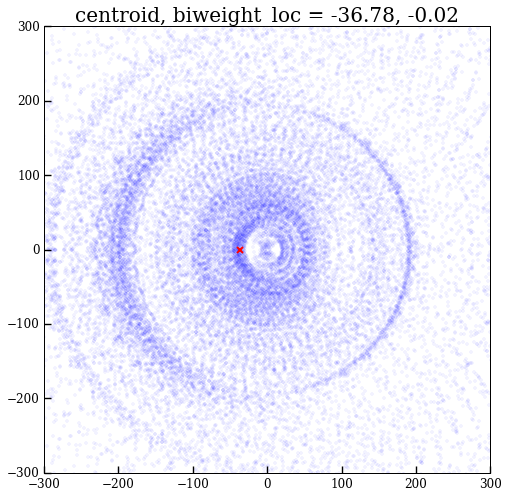

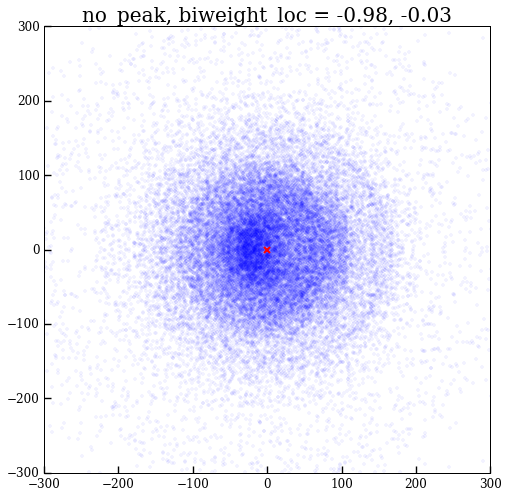

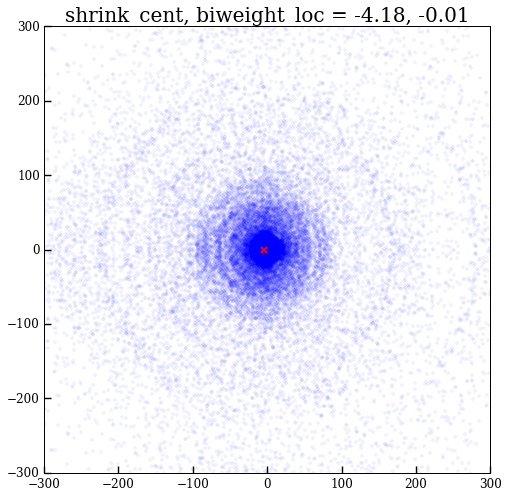

In [784]:
plot_2D_offsets(sum_stat_dom_peak_df, stat_key)

# investigate separations for clusters with low projected $\nu < 1.2$ only for the DOMINANT peak

In [748]:
relaxed_nu_mask = sum_stat_dom_peak_df.total_peaks_dens < 1.2

In [775]:
type(relaxed_nu_mask)

pandas.core.series.Series

In [778]:
bimodal_nu_mask = np.logical_and(
    sum_stat_dom_peak_df.total_peaks_dens > 1.2,
     sum_stat_dom_peak_df.total_peaks_dens < 2.5)
bimodal_nu_mask = pd.Series(bimodal_nu_mask)

In [687]:
sum_stat_dom_peak_df[relaxed_nu_mask].describe()

,BCG,Delta_x_BCG,Delta_x_centroid,Delta_x_shrink_cent,Delta_y_BCG,Delta_y_centroid,Delta_y_shrink_cent,centroid,shrink_cent,peak_id,KDE,Delta_x_KDE,Delta_y_KDE,total_peaks_dens,bin_width,Delta_x_no_peak,Delta_y_no_peak,no_peak
count,14983.000000,14983.000000,14983.000000,14983.000000,14983.000000,14983.000000,14983.000000,14983.000000,14983.000000,14983,14983.000000,14983.000000,14983.000000,14983.000000,14983,14983.000000,14983.000000,14983.000000
mean,4.358005,0.557547,-20.852253,-11.266974,-0.017728,-0.130882,-0.042393,144.947768,80.835345,0,26.201570,-3.291967,-0.008795,1.073158,25,-11.150685,-0.062745,102.297641
std,6.759144,6.157133,119.562433,81.187820,5.143736,123.982261,79.028566,95.343491,80.181932,0,21.159136,23.880519,23.519356,0.067310,0,89.876298,90.390388,76.857110
min,0.020259,-180.288554,-400.232062,-335.360962,-172.665188,-536.774636,-361.103796,2.433943,0.080020,0,0.173973,-115.632805,-141.655940,1.000000,25,-488.906506,-512.078930,0.554121
25%,1.452606,-1.170366,-92.153505,-38.949264,-1.524146,-69.834118,-26.475709,71.117087,18.375323,0,11.881501,-14.640729,-11.641216,1.000000,25,-54.454732,-47.431092,50.101376
50%,2.478769,0.232362,-24.068228,-2.931958,0.007045,-0.138634,0.019393,128.864409,53.262637,0,20.012574,-3.054397,0.053675,1.064193,25,-9.262916,-0.118581,83.524781
75%,5.159628,1.863278,39.758790,16.163213,1.469449,69.703844,26.439957,200.008630,116.958964,0,34.091854,8.165874,11.585048,1.130824,25,41.131462,47.320892,124.373342
max,238.108219,237.284548,536.597742,358.378750,172.619090,536.597670,361.379324,537.855124,362.616745,0,151.078206,132.716008,142.400421,1.199994,25,485.306333,511.741772,518.805732


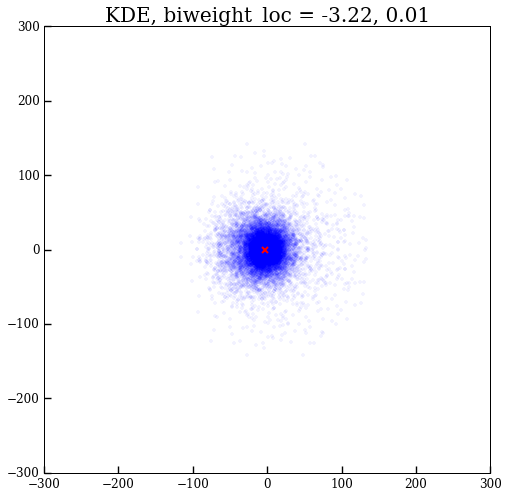

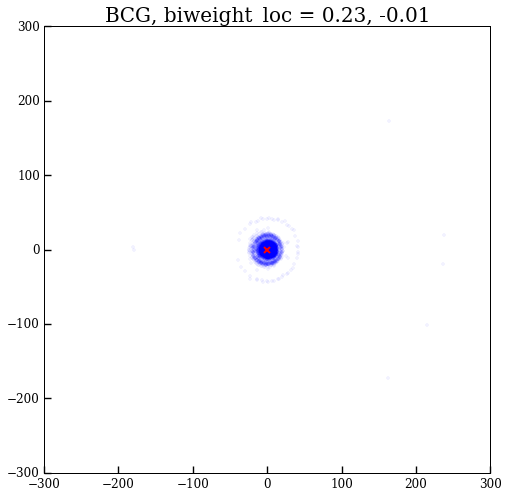

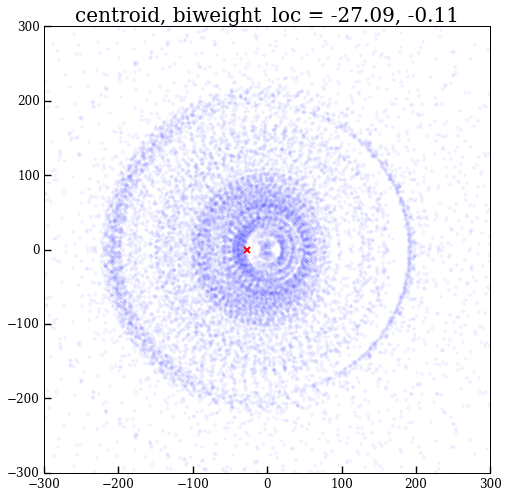

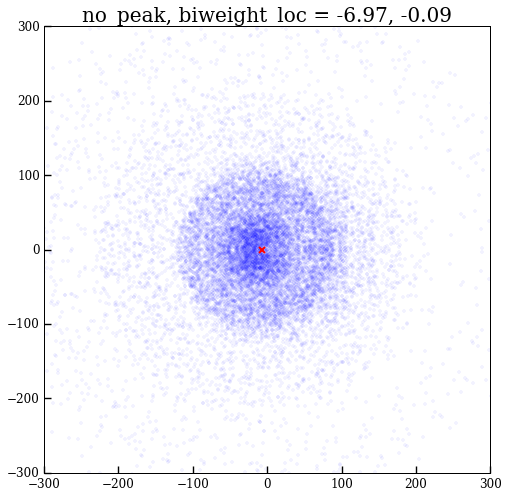

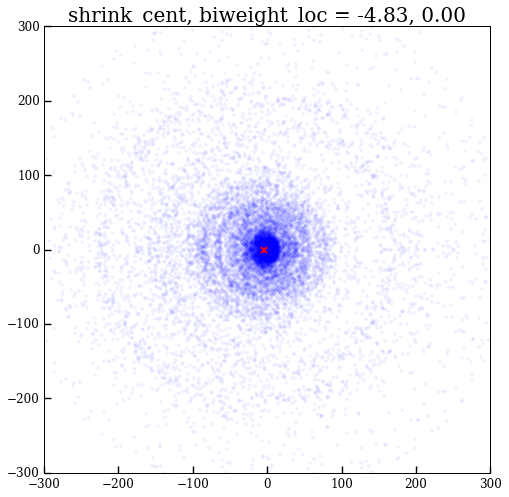

In [765]:
plot_2D_offsets(sum_stat_dom_peak_df[relaxed_nu_mask], stat_key)

In [733]:
import copy
stat_dict_with_centroid = copy.deepcopy(one_direction_stat_dict)
stat_dict_with_centroid[
    "Delta_y_centroid"] = r"$\Delta y_{\rm centroid}$"

In [734]:
stat_dict_with_centroid

{'Delta_y_BCG': '$\\Delta y_{\\rm BCG}$',
 'Delta_y_KDE': "$\\Delta y_{\\rm KDE}'$",
 'Delta_y_centroid': '$\\Delta y_{\\rm centroid}$',
 'Delta_y_no_peak': '$\\Delta y_{\\rm num. dens}$',
 'Delta_y_shrink_cent': "$\\Delta y_{\\rm shrink}'$"}

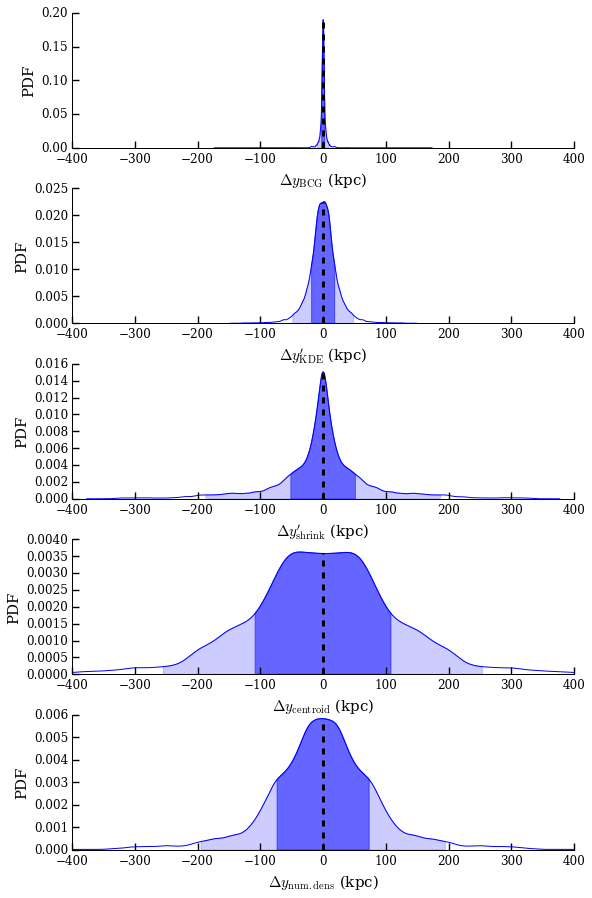

In [823]:
relaxed_dom_peak_sum_stat_df_dict = plot_offset_along_1_dimension(
        sum_stat_dom_peak_df[relaxed_nu_mask], stat_dict_with_centroid,
        save=False, 
        )

# visualize the density interval of BCG offset in log space

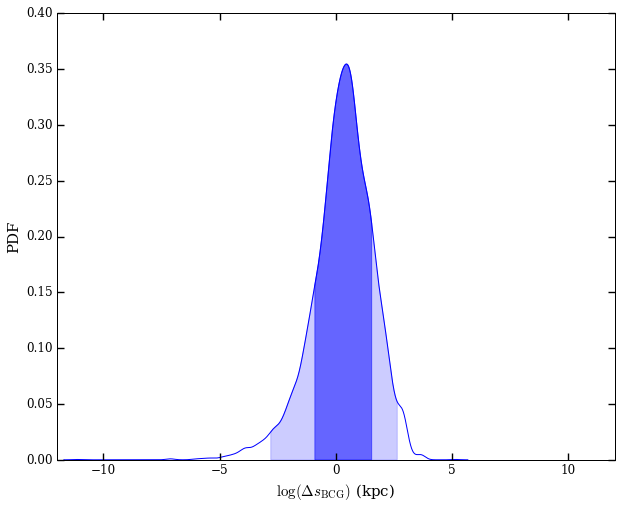

In [746]:
fig = plt.figure()
ax = fig.add_subplot(111)
plotCI.CI_loc_plot(
    np.log(sum_stat_dom_peak_df[nu_mask]['Delta_y_BCG']),
    ax=ax
)
ax.set_xlim(-12, 12)
ax.set_xlabel(r'$\log(\Delta s_{\rm BCG})$ (kpc)'  )
ax.set_ylabel('PDF')

# examine the statistics from bimodal clusters

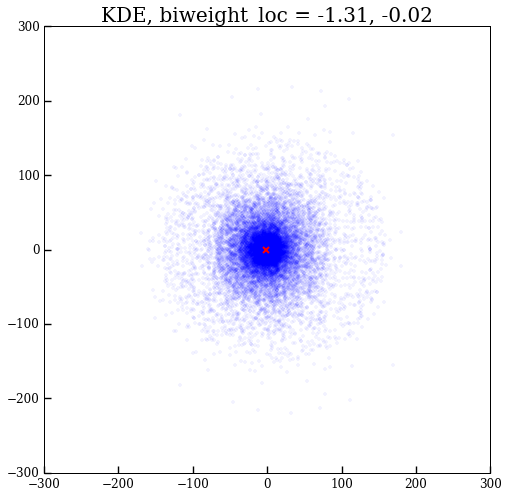

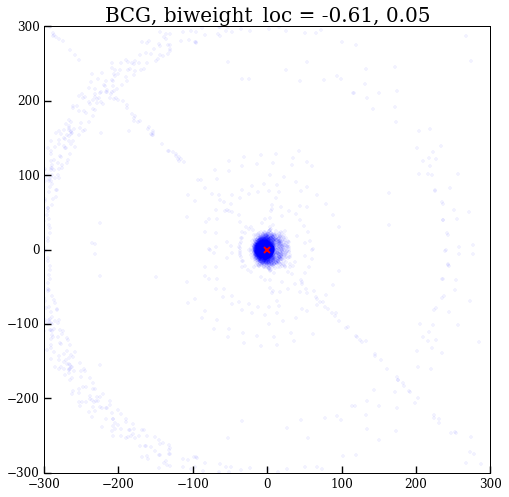

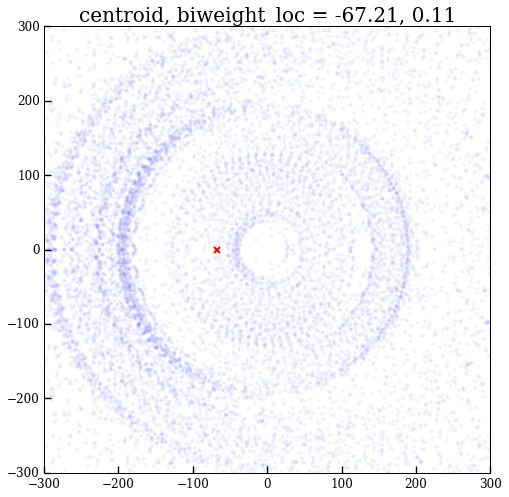

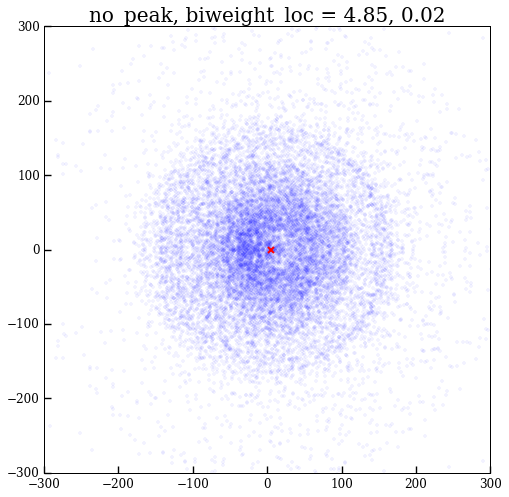

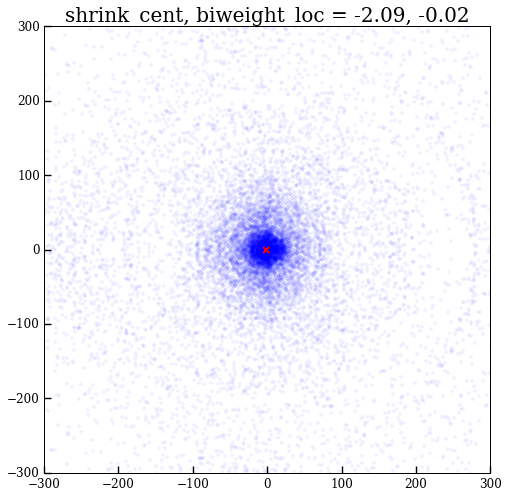

In [780]:
plot_2D_offsets(sum_stat_dom_peak_df[bimodal_nu_mask], stat_key)

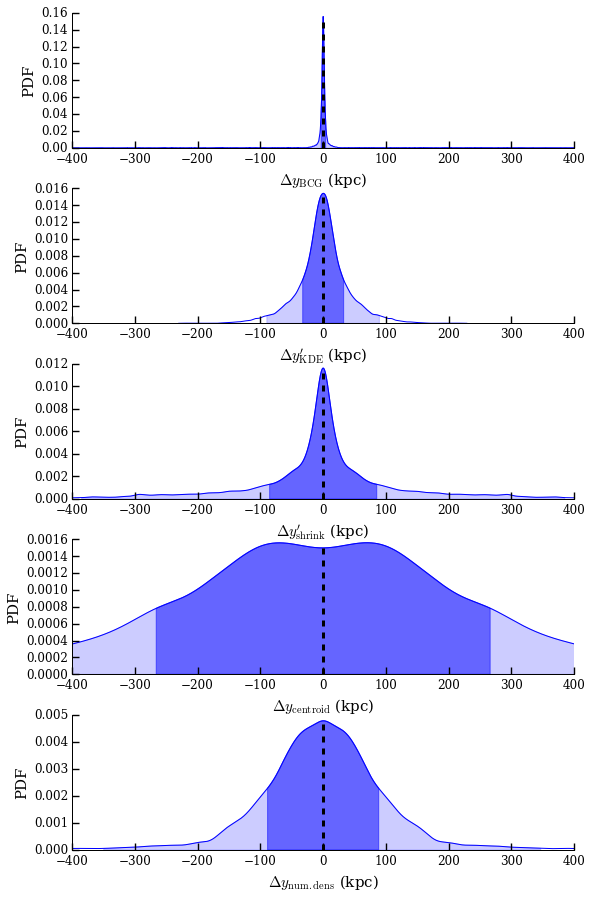

In [825]:
bimodal_dom_peak_sum_stat_df_dict = plot_offset_along_1_dimension(
        sum_stat_dom_peak_df[bimodal_nu_mask], stat_dict_with_centroid,
        save=False
        )

In [782]:
sum_stat_dom_peak_df[bimodal_nu_mask].describe()

,BCG,Delta_x_BCG,Delta_x_centroid,Delta_x_shrink_cent,Delta_y_BCG,Delta_y_centroid,Delta_y_shrink_cent,centroid,shrink_cent,peak_id,KDE,Delta_x_KDE,Delta_y_KDE,total_peaks_dens,bin_width,Delta_x_no_peak,Delta_y_no_peak,no_peak
count,17052.000000,17052.000000,17052.000000,17052.000000,17052.000000,17052.000000,17052.000000,17052.000000,17052.000000,17052,17052.000000,17052.000000,17052.000000,17052.000000,17052,17052.000000,17052.000000,17052.000000
mean,113.953060,-23.772791,-62.140611,-1.885349,37.973270,0.077139,0.017123,356.105602,147.490691,0,44.193672,-1.071104,-0.021317,1.555993,25,-7.964849,-0.059713,145.238523
std,373.580672,293.506699,280.648051,158.741054,253.762025,309.612929,178.523964,227.302761,187.931646,0,35.190853,39.299713,40.570630,0.302706,0,153.878879,171.465544,179.017102
min,0.015291,-2331.323053,-1021.762137,-1089.260820,-1979.971248,-1102.390879,-1083.202951,19.420971,0.214447,0,0.030510,-169.205034,-219.259824,1.200005,25,-1378.666659,-1386.331599,0.539944
25%,1.663683,-3.052570,-217.654788,-38.028047,-1.722854,-168.936307,-38.885384,193.746490,22.639859,0,17.755697,-19.743005,-19.043907,1.316299,25,-51.482497,-56.787297,59.307025
50%,3.302948,-0.676707,-73.456374,-1.754295,0.132963,0.049596,-0.014996,286.784125,70.685266,0,33.645528,-1.004829,-0.030453,1.459365,25,1.688184,0.016475,96.961172
75%,7.807836,0.938652,113.242377,32.428292,2.245696,168.999765,38.862177,476.580516,215.400729,0,61.311855,16.349837,18.965858,1.713079,25,59.413434,56.929085,150.049639
max,2335.025509,2326.801110,1101.390605,968.697331,2331.603636,1100.052472,1084.120501,1102.852008,1227.934114,0,230.850967,180.104871,217.960167,2.498639,25,993.436210,1387.442341,1407.899598


# list of statistics from different relaxedness cut criteria
* update column name
* update row name 

In [854]:
sample_stat_dicts = OrderedDict([
        ("all $\nu$", pd.DataFrame(sym_sum_stat_df_dict).transpose()), 
        ("$\nu < 1.2$", pd.DataFrame(relaxed_dom_peak_sum_stat_df_dict).transpose()), 
        ("$1.2 < \nu < 2.0$", pd.DataFrame(bimodal_dom_peak_sum_stat_df_dict).transpose())])

for k, v in sample_stat_dicts.iteritems():
    ## Pandas cannot output hierarchical indices to table 
    # hier_index = [(k, stat_dict_with_centroid[row]) for row in v.index]
    # hier_index = pd.MultiIndex.from_tuples(hier_index)
    # v.index = hier_index
    v.index = [(k, stat_dict_with_centroid[row]) for row in v.index]
    
    v.columns = [
        u'location', 
        u'lower 68\%', 
        u'lower 95\%', 
        u'lower 99\%', 
        u'upper 68\%', 
        u'upper 95\%', 
        u'upper 99\%']

In [855]:
table_2_results = sample_stat_dicts.values()

In [856]:
with open('../../paper/p_val_table.tex', 'w') as f:
    f.write(table_2_re.to_latex(
            escape=False, float_format=str_formatter))
!wc -l ../../paper/p_val_table.tex

AttributeError: 'list' object has no attribute 'to_latex'

In [853]:
!cat ../../paper/p_val_table.tex

\begin{tabular}{llrrrrrrr}
\toprule
          &                      &  location &  lower 68\% &  lower 95\% &  lower 99\% &  upper 68\% &  upper 95\% &  upper 99\% \\
\midrule
all $\nu$ & $\Delta y_{\rm BCG}$ &         0 &          -3 &         -22 &        -496 &           3 &         456 &        1449 \\
\bottomrule
\end{tabular}
